In [2]:
pip install ussa1976

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 58.2 MB/s eta 0:00:00


Propagator: Error importing from config: No module named 'config'
Propagator: Using fallback default values for critical parameters.

--- Testing propagator.py ---

Test Propagation for LEO-like orbit:
  Initial State: [6678.137, 0.0, 0.0, 0.0, np.float64(7.725760232077136), 0.0]
  Time Span: (0.0, 31536000) s
  Output Timesteps: 8761 points
  J2 Enabled: True
  Drag Enabled: False

Propagation successful. Output states shape: (8761, 6)
  Number of time points returned: 8761
  Initial propagated state: [6678.137         0.            0.            0.            7.72576023
    0.        ]
  Final propagated state:   [-3.25975249e+03 -5.82848659e+03  0.00000000e+00  6.74371053e+00
 -3.76972760e+00  0.00000000e+00]


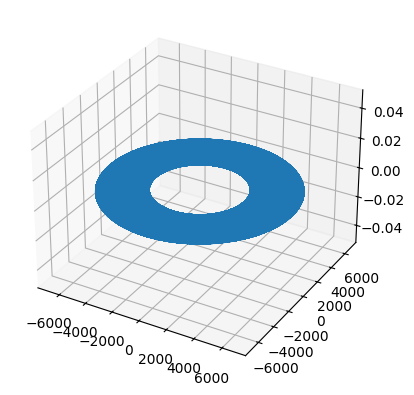

In [17]:
# ML_Orbital_Predictor_Corrector/orbit_dynamics/propagator.py
import numpy as np
import ussa1976
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

try:
    from config import (
        MU_EARTH_KM3_S2,
        R_EARTH_KM,
        J2_EARTH,
        ENABLE_J2_PERTURBATION,
        ENABLE_DRAG_PERTURBATION,
        ODE_SOLVER_METHOD,
        ODE_RELATIVE_TOLERANCE,
        ODE_ABSOLUTE_TOLERANCE,
        OMEGA_EARTH,
        SPACECRAFT_DRAG_COEFF,
        SPACECRAFT_DRAG_AREA_M2,
        SPACECRAFT_MASS_KG
    )
    CONFIG_LOADED = True
    print("Propagator: Successfully imported parameters from config.")
except ImportError as e:
    CONFIG_LOADED = False
    print(f"Propagator: Error importing from config: {e}")
    print("Propagator: Using fallback default values for critical parameters.")
    # Fallback defaults
    MU_EARTH_KM3_S2 = 398600.4418
    R_EARTH_KM = 6378.137
    J2_EARTH = 0.00108263
    ENABLE_J2_PERTURBATION = True
    ENABLE_DRAG_PERTURBATION = False # Default to False if config fails for safety
    ODE_SOLVER_METHOD = 'RK45'
    ODE_RELATIVE_TOLERANCE = 1e-9
    ODE_ABSOLUTE_TOLERANCE = 1e-12
    OMEGA_EARTH = 7.29211576e-5
    SPACECRAFT_DRAG_COEFF = 2.2
    SPACECRAFT_DRAG_AREA_M2 = 5.0
    SPACECRAFT_MASS_KG = 500


# --- ODE Function: Defines the equations of motion ---
def orbital_ode(t,state_vector, mu, r_earth_eq, j2_coeff,
                j2_enabled, drag_enabled, earth_om,
                sc_mass_kg, sc_cd, sc_area_m2):
    """
    Defines the differential equations for orbital motion, including
    two-body gravitation, J2 perturbation, and a placeholder for drag.

    Args:
        t (float): Current time (required by solve_ivp, not always used in EOMs).
        state_vector (array-like): Current state [x, y, z, vx, vy, vz] in km and km/s.
        mu (float): Gravitational parameter of the central body (km^3/s^2).
        r_earth_eq (float): Equatorial radius of the Earth (km) for J2.
        j2_coeff (float): J2 perturbation coefficient.
        j2_enabled (bool): Flag to enable/disable J2 perturbation.
        drag_enabled (bool): Flag to enable/disable drag perturbation.
        sc_mass_kg (float, optional): Spacecraft mass in kg (for drag).
        sc_cd (float, optional): Drag coefficient (for drag).
        sc_area_m2 (float, optional): Drag area in m^2 (for drag).

    Returns:
        list: Derivatives [vx, vy, vz, ax_total, ay_total, az_total].
        :param sc_area_m2:
        :param sc_cd:
        :param sc_mass_kg:
        :param drag_enabled:
        :param j2_enabled:
        :param j2_coeff:
        :param r_earth_eq:
        :param mu:
        :param state_vector:
        :param earth_om:
    """
    x, y, z, vx, vy, vz = state_vector

    # --- Calculate position and velocity magnitudes ---
    r_vec = np.array([x, y, z])
    r_mag_sq = np.dot(r_vec, r_vec) # x**2 + y**2 + z**2
    r_mag = np.sqrt(r_mag_sq)
    r_mag_cubed = r_mag_sq * r_mag # r_mag**3

    # --- 1. Two-Body Gravitational Acceleration ---
    ax_2body = -mu * x / r_mag_cubed
    ay_2body = -mu * y / r_mag_cubed
    az_2body = -mu * z / r_mag_cubed

    accel_total = np.array([ax_2body, ay_2body, az_2body])

    # --- 2. J2 Perturbation (Earth's Oblateness) ---
    if j2_enabled:
        # Formula for J2 acceleration
        # This assumes ECI frame where z-axis is aligned with Earth's rotational axis.

        ax_j2 = (mu*x/r_mag_cubed)*1.5*j2_coeff*(r_earth_eq/r_mag)**2*(5*(z**2/r_mag_sq)-1)
        ay_j2 = (mu*y/r_mag_cubed)*1.5*j2_coeff*(r_earth_eq/r_mag)**2*(5*(z**2/r_mag_sq)-1)
        az_j2 = (mu*z/r_mag_cubed)*1.5*j2_coeff*(r_earth_eq/r_mag)**2*(5*(z**2/r_mag_sq)-1)

        accel_total += np.array([ax_j2, ay_j2, az_j2])

    # --- 3. Atmospheric Drag Perturbatio ---
    if drag_enabled:
        # Use USSA1976 model to calculate density at altitude z
        #h_mag = (r_mag-R_EARTH_KM)
        #h_mag_n1 = h_mag + 0.1 # converts magnitude to meters and adds 0.1m for the range.
        #ds = ussa1976.compute(z=np.arange(h_mag, h_mag_n1, 0.1), variables=["rho"])
        #rho_m = ds["rho"].values[0]
        #rho = rho_m * 1e9 # converts density to per km^3
        rho = 0.221


        v_rel_vec = np.array([vx+earth_om*y, vy-earth_om*x, vz])
        v_rel_sq = np.dot(v_rel_vec,v_rel_vec)
        v_rel = np.sqrt(v_rel_sq)

        ax_d = -0.5*(sc_cd*sc_area_m2/sc_mass_kg)*rho*v_rel*(vx+earth_om*y)
        ay_d = -0.5*(sc_cd*sc_area_m2/sc_mass_kg)*rho*v_rel*(vy-earth_om*x)
        az_d = -0.5*(sc_cd*sc_area_m2/sc_mass_kg)*rho*v_rel*vz

        accel_total += np.array([ax_d, ay_d, az_d])

    # --- Assemble the derivatives ---
    # dY/dt = [dx/dt, dy/dt, dz/dt, dvx/dt, dvy/dt, dvz/dt]
    # where dx/dt = vx, ..., and dvx/dt = ax_total, ...
    derivatives = [vx, vy, vz, accel_total[0], accel_total[1], accel_total[2]]
    return derivatives


# --- Main Propagation Function ---
def propagate_orbit(
        initial_state_vector,
        t_span,
        t_eval,
    ):
    """
    Propagates a single orbit using scipy.integrate.solve_ivp.

    Args:
        initial_state_vector (array-like): Initial state [x, y, z, vx, vy, vz] in km and km/s.
        t_span (tuple): Time interval for integration (t_start_seconds, t_end_seconds).
        t_eval (array-like): Time points (in seconds) at which to store the solution..

    Returns:
        tuple: (times_array, states_array, sol_object)
               - times_array (np.array): Time points corresponding to states_array.
               - states_array (np.array): 2D array where each row is a state vector
                                          [x, y, z, vx, vy, vz] at the corresponding time.
                                          Shape is (len(times_array), 6).
               - sol_object (OdeResult): The full solution object from solve_ivp.
               Returns (None, None, None) if integration fails.
    """

    # --- Set ODE parameters, allowing overrides ---
    ode_p = {
        'mu': MU_EARTH_KM3_S2,
        'r_earth_eq': R_EARTH_KM,
        'j2_coeff': J2_EARTH,
        'j2_enabled': ENABLE_J2_PERTURBATION,
        'drag_enabled': ENABLE_DRAG_PERTURBATION,
        'ode_method': ODE_SOLVER_METHOD,
        'rtol': ODE_RELATIVE_TOLERANCE,
        'atol': ODE_ABSOLUTE_TOLERANCE,
        'sc_mass_kg': SPACECRAFT_MASS_KG,
        'sc_cd': SPACECRAFT_DRAG_COEFF,
        'sc_area_m2': SPACECRAFT_DRAG_AREA_M2,
        'earth_om': OMEGA_EARTH
    }

    # Arguments to pass to the orbital_ode function
    # Order must match the signature of orbital_ode after t and state_vector
    ode_args = (
        ode_p['mu'], ode_p['r_earth_eq'], ode_p['j2_coeff'],
        ode_p['j2_enabled'], ode_p['drag_enabled'],
        ode_p['sc_mass_kg'],
        ode_p['sc_cd'],
        ode_p['sc_area_m2'],
        ode_p['earth_om']
    )

    try:
        solution = solve_ivp(
            fun=orbital_ode,
            t_span=t_span,
            y0=initial_state_vector,
            method=ode_p['ode_method'],
            t_eval=t_eval,
            rtol=ode_p['rtol'],
            atol=ode_p['atol'],
            args=ode_args,
            dense_output=True # Useful if you need to interpolate solution between t_eval points
        )

        if solution.success:
            # solve_ivp returns solution.y with shape (n_states, n_times)
            # Transpose to (n_times, n_states) for easier row-wise access
            return solution.t, solution.y.T, solution
        else:
            print(f"Propagator: Integration failed for ICs: {initial_state_vector}. Message: {solution.message}")
            return None, None, solution # Return solution object for debugging
    except Exception as e:
        print(f"Propagator: Exception during orbit propagation for ICs {initial_state_vector}: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None


# --- Example Usage (for testing this module directly) ---
if __name__ == "__main__":
    print("\n--- Testing propagator.py ---")

    if not CONFIG_LOADED:
        print("WARNING: Configuration not loaded, using fallback parameters for test.")

    # Example Initial Conditions (LEO-like)
    # State: [x, y, z, vx, vy, vz] in km and km/s
    r0_km = R_EARTH_KM + 300  # 700 km altitude
    v0_km_s = np.sqrt(MU_EARTH_KM3_S2 / r0_km) # Circular velocity

    initial_state_leo = [r0_km, 0.0, 0.0, 0.0, v0_km_s, 0.0]
    # Slightly inclined orbit
    # initial_state_leo_inclined = [r0_km, 0.0, 0.0, 0.0, v0_km_s * np.cos(np.deg2rad(10)), v0_km_s * np.sin(np.deg2rad(10))]


    # Time settings for the test propagation
    t_start_sec = 0.0
    t_end_sec = 365*24*3600
    dt_sec = 3600  # Output every 60 seconds

    test_t_span = (t_start_sec, t_end_sec)
    test_t_eval = np.arange(t_start_sec, t_end_sec + dt_sec, dt_sec)

    print(f"\nTest Propagation for LEO-like orbit:")
    print(f"  Initial State: {initial_state_leo}")
    print(f"  Time Span: {test_t_span} s")
    print(f"  Output Timesteps: {len(test_t_eval)} points")
    print(f"  J2 Enabled: {ENABLE_J2_PERTURBATION}")
    print(f"  Drag Enabled: {ENABLE_DRAG_PERTURBATION}")

    times, states, sol_obj = propagate_orbit(
        initial_state_vector=initial_state_leo,
        t_span=test_t_span,
        t_eval=test_t_eval
    )

    if states is not None:
        print(f"\nPropagation successful. Output states shape: {states.shape}")
        print(f"  Number of time points returned: {len(times)}")
        print(f"  Initial propagated state: {states[0, :]}")
        print(f"  Final propagated state:   {states[-1, :]}")

        x_pos = states[:, 0]
        y_pos = states[:, 1]
        z_pos = states[:, 2]

        # ... rest of your plotting code ...
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(x_pos, y_pos, z_pos)
        # ... labels, title, show etc ...
        plt.show()
    else:
        print("\nTest propagation failed.")

